In [1]:
%matplotlib widget

import pickle
from IPython import display
from base64 import b64decode
from pacti.terms.polyhedra import *
from pacti.utils import read_contracts_from_file
from contract_utils import *
import numpy as np
from matplotlib.figure import Figure
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

tuple2float = tuple[float, float]

from generators import *
from plot_utils import *

In [2]:
def show_bounds(c: PolyhedralContract, n: int):
    fsoc = " + ".join([f"{1/n} output_soc{i}" for i in range(1, n+1)])

    print("Task duration bounds:")
    print(f"    step{n-4} dsn: "+str(c.get_variable_bounds(f"duration_dsn{n-4}")))
    print(f"    step{n-3} charging: "+str(c.get_variable_bounds(f"duration_charging{n-3}")))
    print(f"    step{n-2} sbo: "+str(c.get_variable_bounds(f"duration_sbo{n-2}")))
    print(f"    step{n-1} tcm_h: "+str(c.get_variable_bounds(f"duration_tcm_h{n-1}")))
    print(f"    step{n} tcm_dv: "+str(c.get_variable_bounds(f"duration_tcm_dv{n}")))

    print("Power bounds:")
    for i in range(1,n+1):
        print(f"    soc{i}: "+str(c.get_variable_bounds(f"output_soc{i}")))
    print("Science bounds:")
    print(f"    d{n}: "+str(c.get_variable_bounds(f"output_d{n}")))
    print(f"    c{n}: "+str(c.get_variable_bounds(f"output_c{n}")))
    print("Navigation bounds:")
    print(f"    u{n}: "+str(c.get_variable_bounds(f"output_u{n}")))
    print(f"    r{n}: "+str(c.get_variable_bounds(f"output_r{n}")))

    max_soc = c.optimize(fsoc, maximize=True)
    min_soc = c.optimize(fsoc, maximize=False)
    print(f"[min, max] average SOC=[{min_soc}, {max_soc}]")

def show_result(results: np.ndarray, i: int, n: int):
    scenario: PolyhedralContract = results[i][2]
    op_req: PolyhedralContract = results[i][3]
    schedule = scenario.merge(op_req)
    show_bounds(schedule, n)

In [3]:

f5 = open('data/results5.data', 'rb')
results5 = pickle.load(f5)
f5.close()

f20 = open('data/results20.data', 'rb')
results20 = pickle.load(f20)
f20.close()


In [4]:
#show_result(results=results5, i=0, n=5)

In [5]:
#show_result(results=results20, i=2, n=20)

In [6]:
# Copied from hyper-scenarios.py
l_bounds = [
    3.0,  # power: min dns cons
    2.5,  # power: min chrg gen
    0.5,  # power: min sbo cons
    0.5,  # power: min tcm_h cons
    0.5,  # power: min tcm_dv cons
    5.0,  # science: min dsn speed
    3.0,  # science: min sbo gen
    1.0,  # nav: min dsn noise
    1.0,  # nav: min chrg noise
    0.3,  # nav: min sbo imp
    1.2,  # nav: min tcm_dv noise
    0.3,  # nav: min tcm_dv progress
]
u_bounds = [
    5.0,  # power: max dns cons
    5.0,  # power: max chrg gen
    1.5,  # power: max sbo cons
    1.5,  # power: max tcm_h cons
    1.5,  # power: max tcm_dv cons
    6.0,  # science: max dsn speed
    4.0,  # science: max sbo gen
    2.0,  # nav: max dsn noise
    2.0,  # nav: max chrg noise
    0.8,  # nav: max sbo imp
    1.8,  # nav: max tcm_dv noise
    0.8,  # nav: max tcm_dv progress
]

def range_score(ranges: list[tuple2float], index: int) -> float:
    """The score is the ratio of the widths of the range w.r.t bounds"""
    return (ranges[index][1] - ranges[index][0]) / (l_bounds[index] - u_bounds[index])

def scenario_score(ranges: list[tuple2float]) -> float:
    # see make_scenario in hyper-scenarios.py

    score: float = 0
    
    # power-negative
    dsn_cons=range_score(ranges, 0)
    score -= dsn_cons

    sbo_cons=range_score(ranges, 2)
    score -= sbo_cons

    tcmh_cons=range_score(ranges, 3)
    score -= tcmh_cons

    tcmdv_cons=range_score(ranges, 4)
    score -= tcmdv_cons

    # power-positive
    chrg_gen=range_score(ranges, 1)
    score += chrg_gen

    # science-negative
    dsn_speed=range_score(ranges, 5)
    score -= dsn_speed

    # science-positive
    sbo_gen=range_score(ranges, 6)
    score += sbo_gen

    # nav-negative
    dsn_noise=range_score(ranges, 7)
    score -= dsn_noise

    chrg_noise=range_score(ranges, 8)
    score -= chrg_noise

    tcm_dv_noise=range_score(ranges, 10)
    score -= tcm_dv_noise

    # nav-positive
    sbo_imp=range_score(ranges, 9)
    score += sbo_imp

    return score / 11

# Copied from hyper-scenarios.py
op_l_bounds = [
    60.0,  # power: low range of initial soc
    10.0,  # power: low range of exit soc at each step
    10.0,  # alloc: low range of delta t
    60.0,  # sci: low range of d
    40.0,  # nav: low range of u
]
op_u_bounds = [
    90.0,  # power: high range of initial soc
    50.0,  # power: low range of exit soc at each step
    50.0,  # alloc: high range of delta t
    100.0,  # sci: high range of  d
    90.0,  # nav: high range of  u
]

def op_range_score(values: np.ndarray, index: int) -> float:
    """The score is the ratio of the value to the bound range"""
    return values[index] / (op_u_bounds[index] - op_l_bounds[index])

def op_requirement_score(values: np.ndarray) -> float:
    # see make_op_requirements5, make_op_requirements20 in hyper-scenarios.py

    score: float = 0

    entry_soc=op_range_score(values, 0)
    score += entry_soc

    min_soc=op_range_score(values, 1)
    score += min_soc

    d_entry=op_range_score(values, 2)
    score += d_entry

    u_entry=op_range_score(values, 3)
    score += u_entry

    return score / 4


In [7]:
def plot_values(r, col1:int, col2:int, metric:str) -> Figure:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xs = [scenario_score(r[i][0]) for i in range(0, len(r))]
    ys = [op_requirement_score(r[i][1]) for i in range(0, len(r))]
    zs1 = [r[i][col1] for i in range(0, len(r))]
    ax.scatter(xs, ys, zs1)
    zs2 = [r[i][col2] for i in range(0, len(r))]
    ax.scatter(xs, ys, zs2)
    ax.set_xlabel('scenario score')
    ax.set_ylabel('operational requirement score')
    ax.set_zlabel(metric)
    return fig

def plot_range2(r, col:int, metric:str) -> Figure:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xs = [scenario_score(r[i][0]) for i in range(0, len(r))]
    ys = [op_requirement_score(r[i][1]) for i in range(0, len(r))]
    zs0 = [r[i][col][0] for i in range(0, len(r))]
    zs1 = [r[i][col][1] for i in range(0, len(r))]
    ax.scatter(xs, ys, zs0)
    ax.scatter(xs, ys, zs1)
    ax.set_xlabel('scenario score')
    ax.set_ylabel('operational requirement score')
    ax.set_zlabel(metric)
    return fig

In [8]:
print(377/60000 * 100)
print(100/60000 * 100)

0.6283333333333333
0.16666666666666669


In [9]:
# 4: min_soc
# 5: max_soc
# 6: u
# 7: r
# 8: c
# plot_values(results5, col1=4, col2=5, metric="min,max soc")

# plot_range2(results5, col=6, metric="traj. uncertainty")

# plot_range2(results5, col=7, metric="rel. traj. progress")

# plot_range2(results5, col=8, metric="cumulative science")

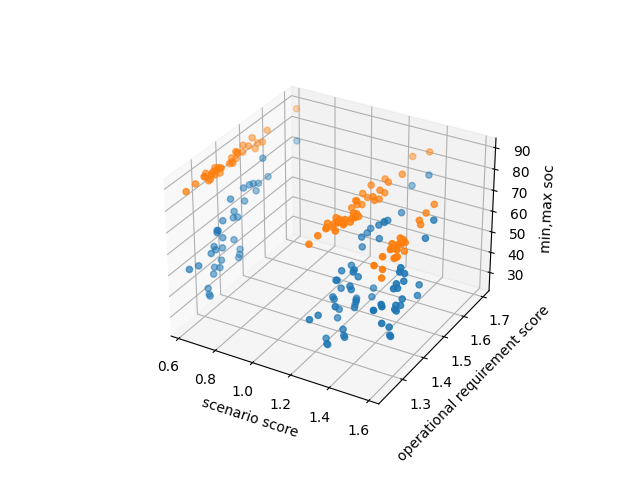

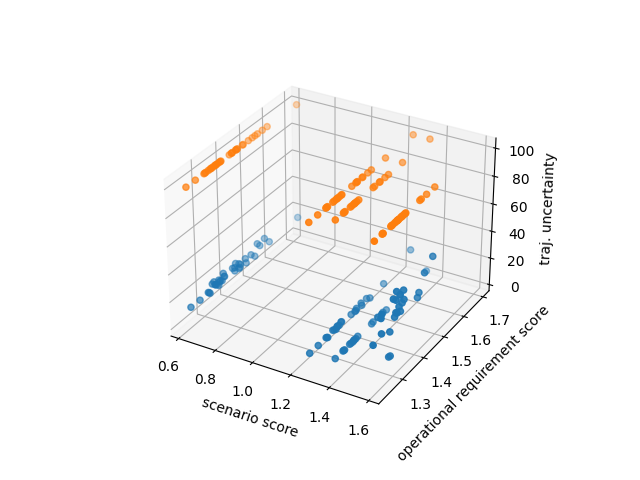

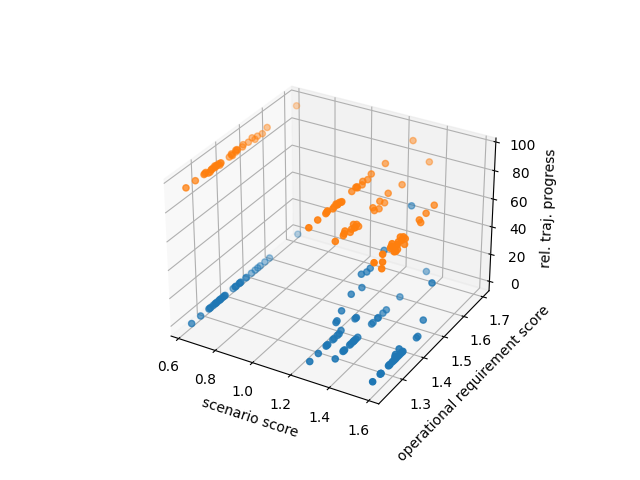

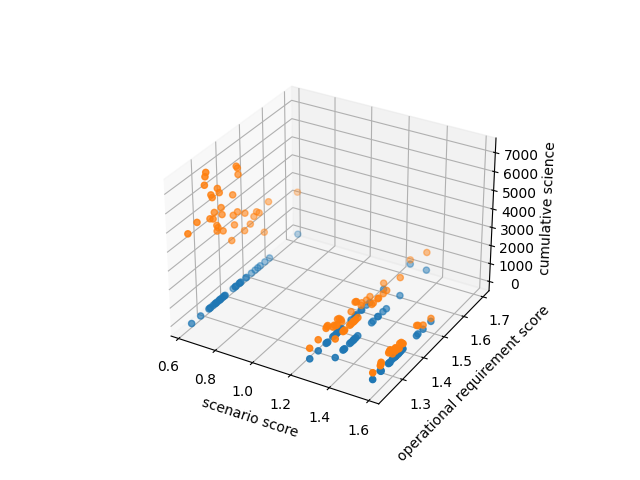

In [10]:

pp = PdfPages(f"figures/results20-min-max-soc.pdf")
fig=plot_values(results20, col1=4, col2=5, metric="min,max soc")
pp.savefig()
pp.close()

pp = PdfPages(f"figures/results20-trajectory-estimation-uncertainty.pdf")
fig=plot_range2(results20, col=6, metric="traj. uncertainty")
pp.savefig()
pp.close()

pp = PdfPages(f"figures/results20-relative-trajectory-progress.pdf")
fig=plot_range2(results20, col=7, metric="rel. traj. progress")
pp.savefig()
pp.close()

pp = PdfPages(f"figures/results20-cumulative-science-data.pdf")
fig=plot_range2(results20, col=8, metric="cumulative science")
pp.savefig()
pp.close()